# Game of Life


The [Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern (generation 0) constitutes the "seed" of the system.
Time is considered discrete, and each time step (sometimes called a tick), the previous rules are applied simultaneously to every cell in the grid; "births" and "deaths" are immediate.
Each generation is a pure function of the previous generation alone.


## Assignments

* Begin by implementing the GoF's rules and create few examples with basic seeds in small dimensions. Hint: create `.gif` animations from sequences of still `.png` images
* Implement examples of the three categories of patterns *still lifes*, *oscillators* and *spaceships* (check the [wiki link](http://en.wikipedia.org/wiki/Conway's_Game_of_Life))
* Analyse the evolutions of these patterns in terms of frequency (the number of cycles required to return to the original configuration, if any), occupancy (how many alive cells there are at every step of the game), replication or heat (the average number of cells that change state at each generation), speed (if applicable), etc.
* Increase the size of the GoF's world and play with more advanced and complex patterns

# Game of Life implementation

In [247]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from functools import partial
from scipy import optimize
from scipy.signal import find_peaks
from scipy.signal import convolve2d

Many different types of patterns occur in GoF, the most common are classified according to their behaviour and can be found [here](https://conwaylife.com/patterns/).
In particular we use `loadPattern()` function to store a particular pattern in a multidimensional numpy array, sparing us the time to manually implement them.

To implement the Conway's Game of Life we call the function `playGame` passing as parameter the the loaded initial configuration (seed).
At each time step the `update()` function is called to update the grid applying the GoF rules.
This function handles all the logic of the game and it's built to allow us to run some analysis on the evolution of the game (as discussed in the next section).

Finally, we store all the generated frames in ``.gif`` file to show the final result.

In [248]:
ON = 1 # Alive cell value
OFF = 0   # Dead cell value

n_steps = 50 # Number of steps done in the game
inter = 100  # Time in ms between each frame (step of the game) in the GIF

def update(frame_num, img, grid, initial_grid=None, period=None, occupancy=None, heat=None):
    """
    Update the grid applying the GoF rules:
    1. Any live cell with fewer than two live neighbors dies, as if by underpopulation.
    2. Any live cell with two or three live neighbors lives on to the next generation.
    3. Any live cell with more than three live neighbors dies, as if by overpopulation.
    4. Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.
    This function takes a numpy array representing the current generation at a specific step (time).
    Optional:
    If initial_grid and period arguments are passed, it checks if the new computed configuration is equal to the original one.
    If occupancy argument is passed, it calculates how many cells are alive at current step.
    If the heat argument is passed, it computes the difference in occupancy between current grid and updated grid.
    
    Parameters
    ----------
    frame_num : int
        Current frame (step) number.
    img : AxesImage
        Input image.
    grid : ndarray
        Current generation.
    initial_grid : ndarray, optional
        Original configuration.
    period : ndarray, optional
        List to keep track of the step where the pattern return to orignal configuration.
    occupancy : ndarray, optional
        List of numbers of alive cells at each step.
    heat : ndarray, optional
        List of numbers of cells that changed state at each step.
    
    Returns
    -------
    img : AxesImage
        Output image
    """

    # Apply game rules via 2D convolution
    # Source: https://www.jpytr.com/post/game_of_life/
    kernel = np.array(
        [[1, 1, 1],
         [1, 0, 1],
         [1, 1, 1]])

    total = convolve2d(grid, kernel, mode='same', boundary="wrap")
    survive = grid * (total >= 2) * (total <= 3)
    
    newGrid = np.where(total == 3, ON, survive)
    img.set_data(newGrid)

    # update statistic metrics
    if heat is not None:
        heat[frame_num] = np.sum(np.not_equal(grid, newGrid))

    if initial_grid is not None and period is not None:
        if np.array_equal(newGrid, initial_grid):
            period[frame_num] = 1

    if occupancy is not None:
        occupancy[frame_num] = np.sum(newGrid == ON)

    # Update grid pattern
    grid[:] = newGrid[:]

    return img


def playGame(seed, time):
    """
    Start the game with a given seed and finite evolution time.
    
    Parameters
    ----------
    seed : ndarray
        Initial generation.
    time : int
        Total number of steps.
    
    Returns
    -------
    ani_out : FuncAnimation
        Output animation.
    period : ndarray
        List to keep track of the step where the pattern return to original configuration.
    occupancy : ndarray
        List of numbers of alive cells at each step.
    heat : ndarray
        List of numbers of cells that changed state at each step.
    """

    # Plot initial seed
    fig, ax = plt.subplots()
    img = ax.imshow(seed, interpolation='nearest')
    plt.plot()

    # Copy original configuration
    igrid = seed.copy() 
    
    # Preallocate statistics arrays
    period, occupancy, heat = np.zeros(time), np.zeros(time), np.zeros(time)

    # Set up the animation and save the first frame
    ani_out = animation.FuncAnimation(fig, 
                                partial(update, img = img, grid = seed, 
                                        initial_grid = igrid, 
                                        period = period, occupancy = occupancy, 
                                        heat = heat),
                                frames = time, interval = inter)

    return ani_out, period, occupancy, heat
    
def loadPattern(file_path, rows=None, columns=None, loc=(0,0)):
    """
    Load an initial pattern from file.
    Initial position and grid size can be specified.
    
    Parameters
    ----------
    file_path : string
        Path to input pattern.
    rows : int, optional
        Position along rows.
    columns : int, optional
        Position along columns.
    loc : tuple, optional
        Grid size.
    
    Returns
    -------
    grid : ndarray
        Initial pattern.
    """

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Remove whitespaces and ignore lines starting with '!'
    lines = [line.strip() for line in lines if not line.startswith('!')]

    if rows == None:
        rows = len(lines)
    if columns == None:
        columns = max(len(line) for line in lines) 
    
    # Pad shorter lines with zeros to make them equal in length
    max_length = max(len(line) for line in lines) 
    lines_padded = [line.ljust(max_length, '.') for line in lines]

    # Load the pattern in the grid
    grid = np.zeros((rows, columns))
    pattern = np.array([[OFF if cell == '.' else ON for cell in line] for line in lines_padded])
    
    # Check if the pattern fits in the grid
    if loc[0] > rows or loc[1] > columns:
        raise ValueError("Invalid location parameter")
    
    if loc[0] + pattern.shape[0] > rows or loc[1] + pattern.shape[1] > columns:
        raise ValueError("The pattern overflows the grid")
    
    grid[loc[0]:loc[0]+pattern.shape[0], loc[1]:loc[1]+pattern.shape[1]] = pattern
    
    return grid

## Analysis
Regarding the analysis, we mainly study the occupancy (how many alive cells there are at every step of the game), the heat (the number of cells that change state at each step), their averages and their period (if they are periodic).

For _Oscillators_ patterns, which return to their initial state after a finite number of steps we also analyise the period (the number of steps before going back to the original state).

Moreover, for _Spaceships_ patterns, we analyze the speed: the number of cells that it has been displaced by after it has gone through one period (the number of steps before returning to the original configuration but in different position).
Speeds are measured in reference to the speed of light, denoted by c, which is the fastest possible speed at which any effect can propagate.

In [249]:
def computePeriod(x):
    """
    Compute the period of a periodic real sequence by analyzing the self-convolution 
    of the sequence obtained through the FFT.

    Parameters
    ----------
    x : ndarray
        Input sequence.
    
    Returns
    -------
    period : int 
        Period of the sequence or -1 is the input is not periodic.
    """
    
    # Remove DC component
    x = x - np.mean(x)

    # Compute real-valued FFT
    fft = np.fft.rfft(x)

    # Compute the self-convolution and normalize it
    # (If first element is zero then the sequence has period 1)
    selfconvol = np.fft.irfft(abs(fft)) 
    if selfconvol[0] == 0:
        return 1
    selfconvol = selfconvol / selfconvol[0]

    # Get the peaks of the self-convolution (only first half because symmetry)
    # And filter only peaks above a certain threshold
    peaks, _ = find_peaks(selfconvol[0:len(x)//2])
    filtered_peaks = peaks[selfconvol[peaks] > 0.4]

    # Get the index of the maximum peak
    if np.size(filtered_peaks) > 0:
        return filtered_peaks[selfconvol[filtered_peaks].argmax()]

    return -1


def analyseOccupancy(occupancy, check_freq=False):
    """
    Plot the evolution over time of the number of alive cells and the average.
    If specified compute also the period of the occupancy.

    Parameters
    ----------
    occupancy : ndarray
        List of alive cells at each step.
    check_freq : boolean, optional
        Flag whether to compute the period of the occupancy or not.
    
    Returns
    -------
    avg_occ: int 
        Average value of occupancy.
    occ_period : int
        Period of the occupancy (if any).
    """
    
    n_occ = len(occupancy)

    # Compute the average of occupancy
    if n_occ > 0:
        avg_occ = round(np.sum(occupancy) / n_occ)
        
    # Plot occupancy and average value
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(n_occ), occupancy, marker="o", label='Occupancy')
    ax.axhline(avg_occ,label='Avg. occupancy', color='r')
    ax.set_xlabel("Time [unit step]")
    ax.set_ylabel('No. alive cells')
    
    plt.title('Occupancy vs time')
    plt.legend()
    plt.tight_layout()

    # Compute the period of occupancy
    if check_freq:
        occ_period = computePeriod(occupancy)

        return avg_occ, occ_period

    return avg_occ


def analyseHeat(heat, check_freq=False):
    """
    Plot the evolution over time of the number of cells that change state at each step and the average.
    If specified compute the period of the heat.

    Parameters
    ----------
    heat : ndarray
        List of number of cells that change state at every step.
    check_freq : boolean, optional
        Flag whether to compute the period of the occupancy or not.

    Returns
    -------
    avg_heat : int
        Average value of heat.
    heat_period : int
        Period of the heat (if any).
    """
    
    n_heat = len(heat)

    # Compute the average of heat
    if n_heat > 0:
        avg_heat = round(np.sum(heat) / n_heat)

    # Plot heat and average value
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(n_heat), heat, marker="o", label='State changes')
    ax.axhline(avg_heat, label='Avg. state changes', color='r')
    ax.set_xlabel("Time [unit step]")
    ax.set_ylabel('No. of state change')
    
    plt.title('No. cells that change state vs time')
    plt.legend()
    plt.tight_layout()

    # Compute the period of heat
    if check_freq:
        heat_period = computePeriod(heat)

        return avg_heat, heat_period

    return avg_heat

# Stochastic example
This and the next sections all have the same structure:
- Initialize the grid with a pattern (which usually is loaded from a file).
- Call the `playGame` function.
- Show the seed.
- Save and show the animation.

In this section we initialize the game with a random generatly seed and let it evolve just for the sake of demonstration.

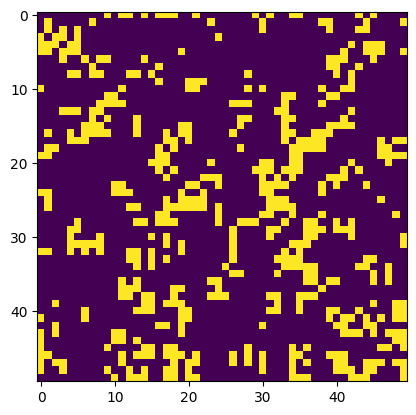

In [250]:
# Set the size of the grid
N = 50

# Generate a random grid
random_grid = np.random.choice([ON, OFF], N*N, p=[0.2, 0.8]).reshape(N, N)

random_out, random_period, random_occupancy, random_heat = playGame(random_grid, n_steps)

In [251]:
# Save and show animation
gif_name = 'random_example.gif'
random_out.save(gif_name, writer = 'pillow', fps = 5)

Image(url=gif_name)

## Analysis
Once we have obtained all the generations, we can study the evolution over time.
Being the evolution randomic in this case there's little to say.

More interesting evolutions are showed in the following.

The average number of alive cells is 326
The occupancy is not periodic


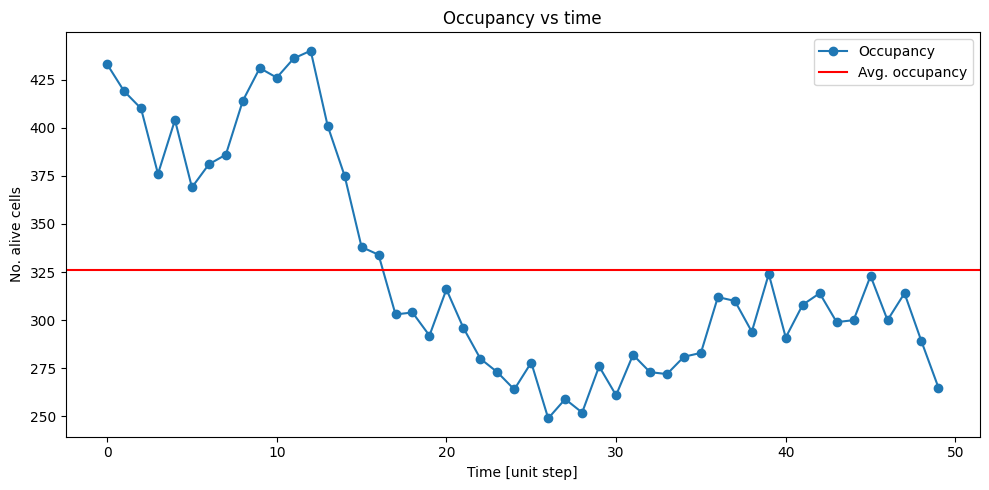

In [252]:
avgocc_random, periodocc_random = analyseOccupancy(random_occupancy, True)

print("The average number of alive cells is", avgocc_random)
if periodocc_random > 0:
    print('The number of alive cells has period', periodocc_random)
else:
    print('The occupancy is not periodic')

The average number of cells that change state at each generation is 278
The heat is not periodic


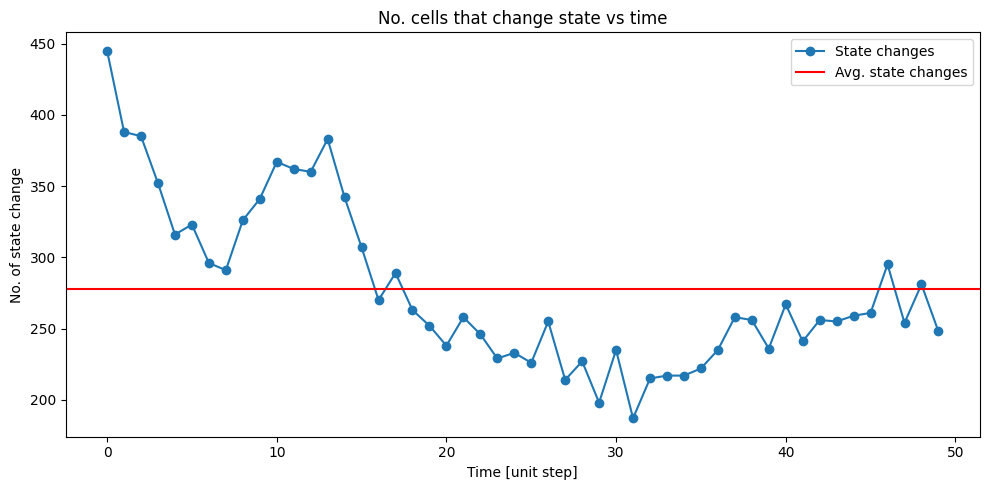

In [253]:
heat_random, periodheat_random = analyseHeat(random_heat, True)

print("The average number of cells that change state at each generation is", heat_random)
if periodheat_random > 0:
    print('The number of alive cells has period', periodheat_random)
else:
    print('The heat is not periodic')

In [254]:
if any(random_period):
    print('The pattern is periodic with period', computePeriod(random_period))
else:
    print('The pattern is not periodic')

The pattern is not periodic


# Still life example
A _Still life_ is a pattern that does not change from one step to the next.
Specifically we start the game with a seed called _Beehive at loaf_.<br>
As its name suggest, with this seed the game doesn't evolve: the alive cells are always the same both in number and in location, it's an equilibrium point.

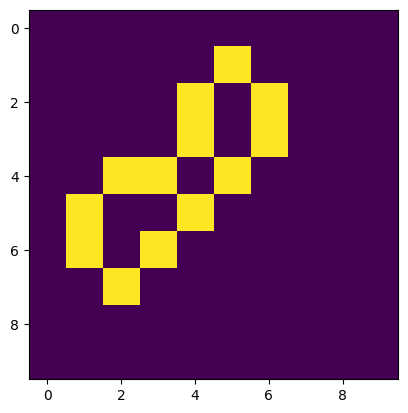

In [255]:
# Load pattern from file.
still_pattern = 'beehiveatloaf.cells.txt'
still_grid = loadPattern(still_pattern, 10, 10, (1, 1))

still_out, still_period, still_occupancy, still_heat = playGame(still_grid, n_steps)

In [256]:
# Save and show animation
gif_name = 'beehiveatloaf.gif'
still_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

## Analysis
As expected the occupancy is constant over time and no cell change state at each step.

Note that still life patterns are said to have period 1, since they go back to the original configuration at each step.

The average number of alive cells is 13
The number of alive cells has period 1


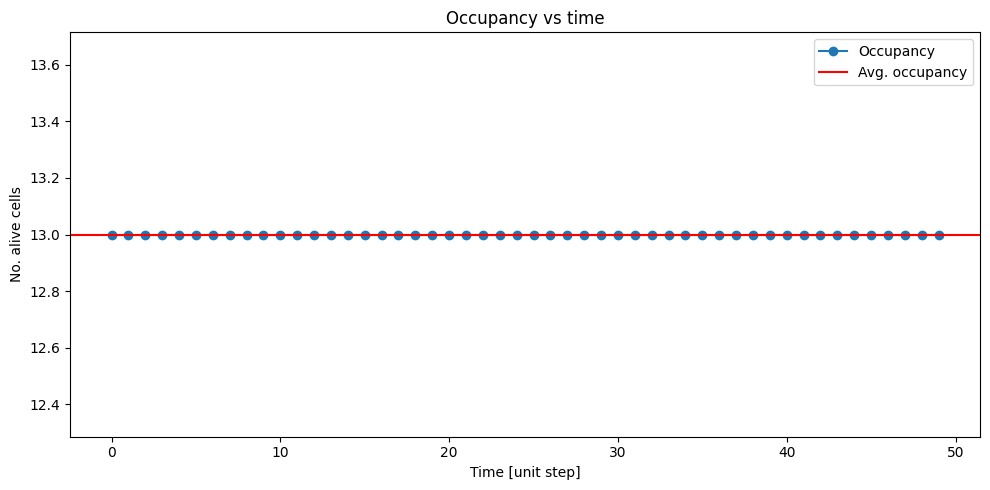

In [257]:
avgocc_still, periodocc_still = analyseOccupancy(still_occupancy, True)
print("The average number of alive cells is", avgocc_still)
print('The number of alive cells has period', periodocc_still)

The average number of cells that change state at each generation is 0
The average number of cells that change state at each generation has period 1


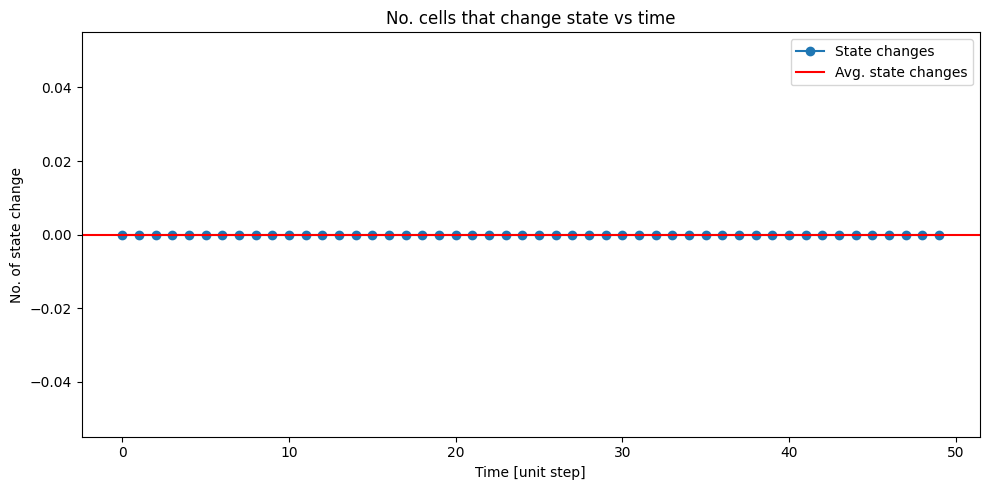

In [258]:
heat_still, periodheat_still = analyseHeat(still_heat, True)
print("The average number of cells that change state at each generation is", heat_still)
print("The average number of cells that change state at each generation has period", periodheat_still)

In [259]:
print('The pattern is periodic with period', computePeriod(still_period))

The pattern is periodic with period 1


# Spaceship example
A _Spaceship_ is a pattern which reappears after a certain number of steps in the same orientation but in a different position.
In this section we start with a particular pattern called _Big Glider_.
It was the first known diagonal spaceship.

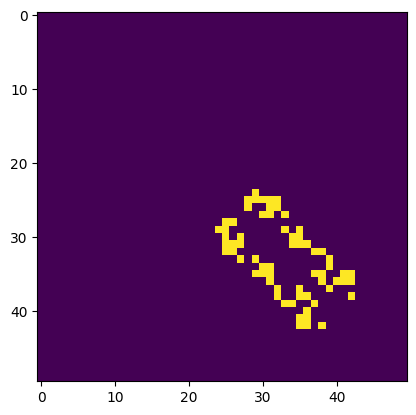

In [260]:
# Load patterns from file
glider_pattern = 'bigglider.cells.txt'
glider_grid = loadPattern(glider_pattern, 50, 50, (25,25))

glider_out, glider_period, glider_occupancy, glider_heat = playGame(glider_grid, n_steps)

In [261]:
# Save and show animation
gif_name = 'bigglider.gif'
glider_out.save(gif_name, writer='pillow', fps=4)


Image(url=gif_name)

## Analysis
By definition of spaceships patterns, the occupancy and the heat are periodic with the same period.
This fact is shown by the following plots.

Moreover, the speed of this spaceship can be easily compute as the inverse of the occupancy period.

The average number of alive cells is 68
The number of alive cells has period 4


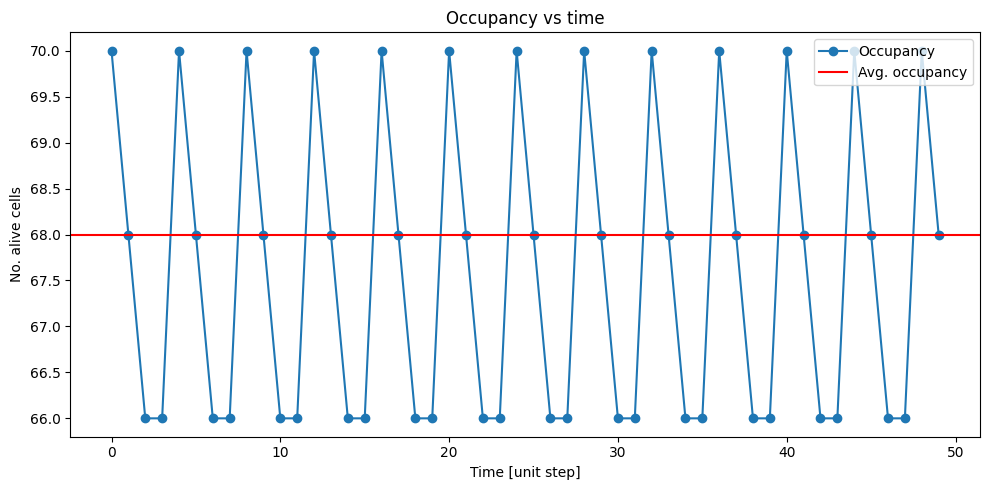

In [262]:
avgocc_glider, periodocc_glider = analyseOccupancy(glider_occupancy, True)
print("The average number of alive cells is", avgocc_glider)
print('The number of alive cells has period', periodocc_glider)

The average number of cells that change state at each generation is 61
The average number of cells that change state at each generation has period 4


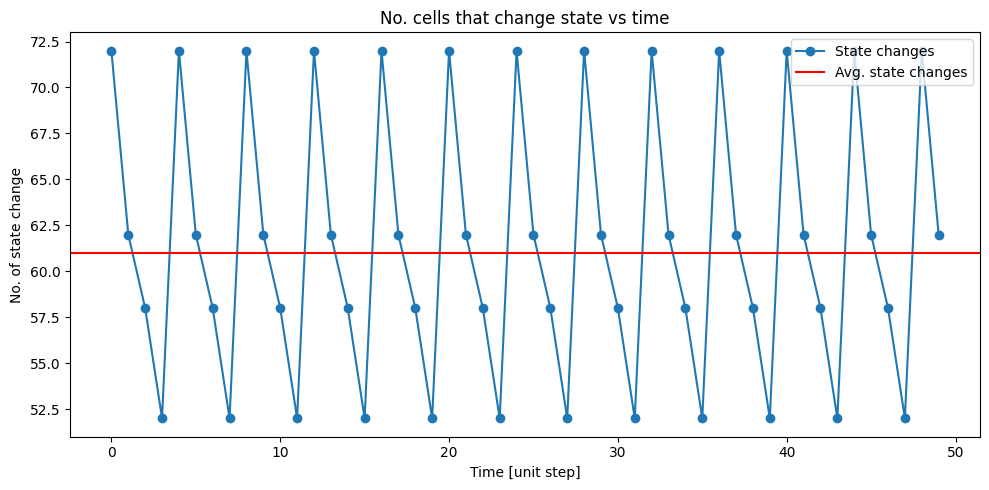

In [263]:
heat_glider, periodheat_glider = analyseHeat(glider_heat, True)
print("The average number of cells that change state at each generation is", heat_glider)
print("The average number of cells that change state at each generation has period", periodheat_glider)

In [264]:
print(f"This spaceship has speed (1/{periodocc_glider})*c")

This spaceship has speed (1/4)*c


# Oscillator example
An _Oscillator_ is a pattern that returns to its original state, in the same orientation and position, after a finite number of steps.
The smallest number of generations it takes before the pattern returns to its initial condition is called the period of the oscillator.

In this section we study a pattern called Koksgalaxy, which has period 8.

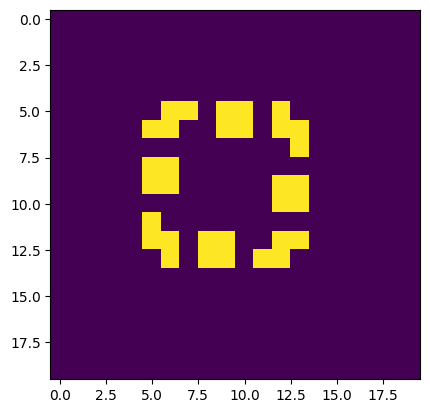

In [265]:
# Load patterns from file.
koksgalaxy = 'koksgalaxy.cells.txt'
koksgalaxy_grid = loadPattern(koksgalaxy, 20,20, (5,5))

koksgalaxy_out, koksgalaxy_period, koksgalaxy_occupancy, koksgalaxy_heat = playGame(koksgalaxy_grid, n_steps)

In [266]:
# Save and show animation
gif_name = 'koksgalaxy_out.gif'
koksgalaxy_out.save(gif_name, writer='pillow', fps=2)

Image(url=gif_name)

## Analysis
Being this pattern periodic, it must follow that the occupancy and heat have the same period which has to be equal to the period of the pattern.

This fact is confirmed by the following plots.

The average number of alive cells is 41
The number of alive cells has period 8


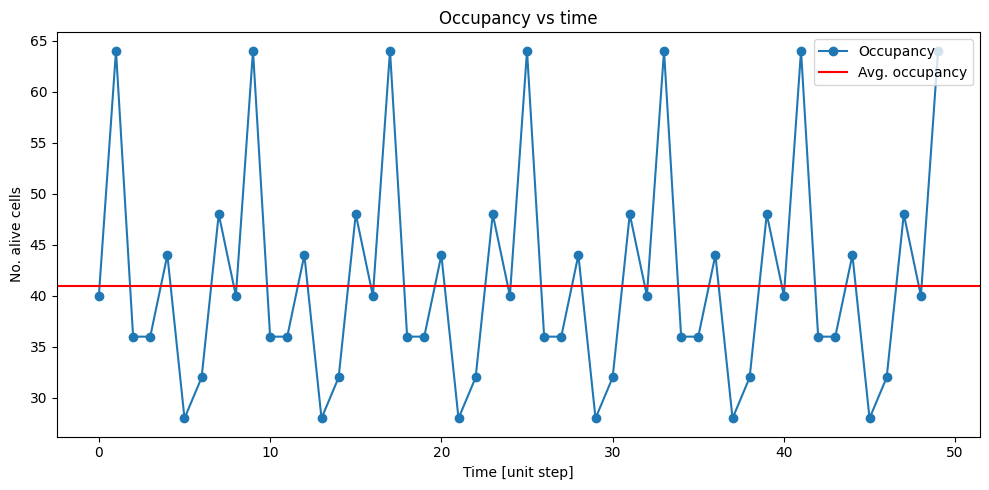

In [267]:
avgocc_koksgalaxy, periodocc_koksgalaxy = analyseOccupancy(koksgalaxy_occupancy, True)
print("The average number of alive cells is", avgocc_koksgalaxy)
print('The number of alive cells has period', periodocc_koksgalaxy)

The average number of cells that change state at each generation is 39
The average number of cells that change state at each generation has period 8


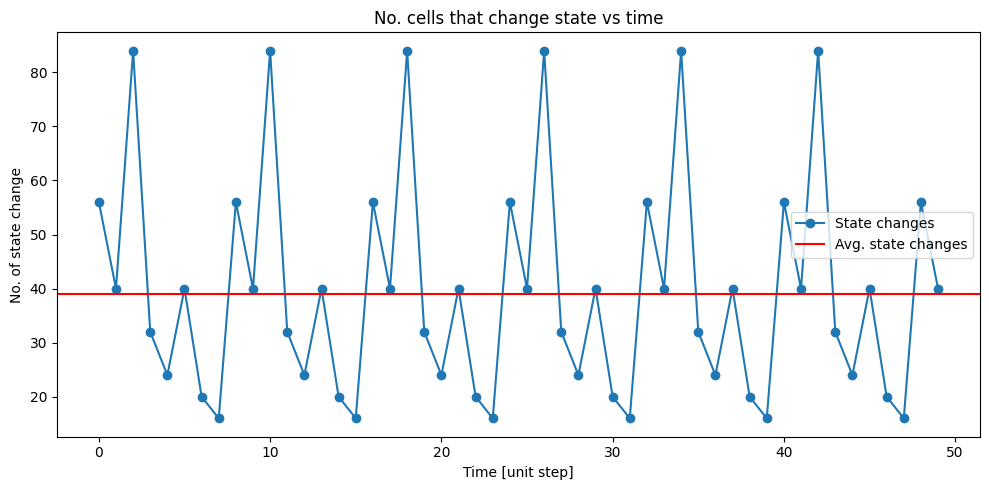

In [268]:
heat_koksgalaxy, periodheat_koksgalaxy = analyseHeat(koksgalaxy_heat, True)
print("The average number of cells that change state at each generation is", heat_koksgalaxy)
print("The average number of cells that change state at each generation has period", periodheat_koksgalaxy)

In [269]:
print('The pattern is periodic with period', computePeriod(koksgalaxy_period))

The pattern is periodic with period 8


# Quadratic growth pattern
A quadratic growth is a pattern which can grow indefintely with a rate proportional to t^2, where t is the number of steps that a pattern has been run.

In this section we study the Teeth pattern, one of the smallest patterns with quadratic growth.

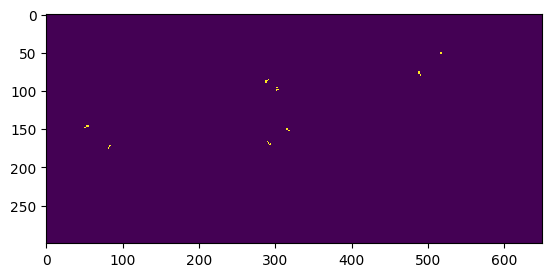

In [270]:
# Load patterns from file.
teeth = 'teeth.cells.txt'
teeth_grid = loadPattern(teeth, 300,650, (50,50))

teeth_out, teeth_period, teeth_occupancy, teeth_heat = playGame(teeth_grid, 1000)

In [271]:
# Save and show animation
gif_name = 'teeth.gif'
teeth_out.save(gif_name, writer='pillow', fps=60)

Image(url=gif_name)

## Analysis
We let it run for 1000 steps, enabling us to observe the quadratic growth of occupancy.
To achieve this, we employed a quadratic fit which gives us a high accuracy.

Moreover, we can observe that also the heat increases with time.
We also in this case employed a quadratic fit which in this case gives a slightly lower accuracy.

In [275]:
# Fit quadratic function
def f(x, a, b, c):
    return a * x**2 + b * x + c
    
def fit(y):
    x = np.arange(len(y))
    popt, _ = optimize.curve_fit(f, x, y, full_output=False)
    
    a_fit, b_fit, c_fit = popt
    y_fit = f(x, a_fit, b_fit, c_fit)
    
    # Check the goodnes of fit
    y_hat = f(x, a_fit, b_fit, c_fit)
    
    ssr = np.sum((y_hat - y)**2)
    tss = np.sum((np.mean(y) - y)**2)
    
    rsq = 1 - ssr / tss
    print(f"Goodness of quadratic fit: {np.sqrt(rsq)*100:.2f}%")
    
    plt.plot(x, y_fit, label='Quadratic Fit', color='cyan')
    plt.legend()
    plt.show()

The average number of alive cells is 1575
Goodness of quadratic fit: 97.91%


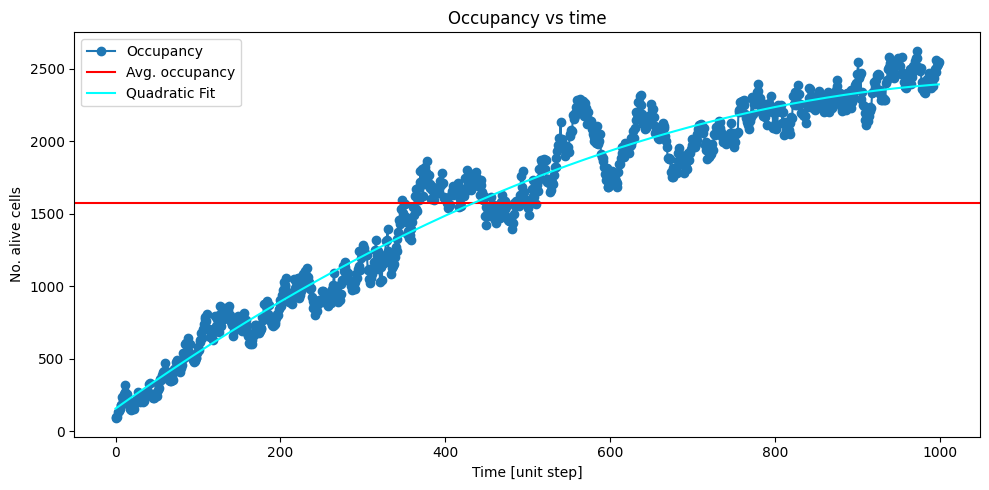

In [276]:
avgocc_teeth = analyseOccupancy(teeth_occupancy)
print("The average number of alive cells is", avgocc_teeth)

fit(teeth_occupancy)

The average number of cells that change state at each generation is 1042
Goodness of quadratic fit: 93.55%


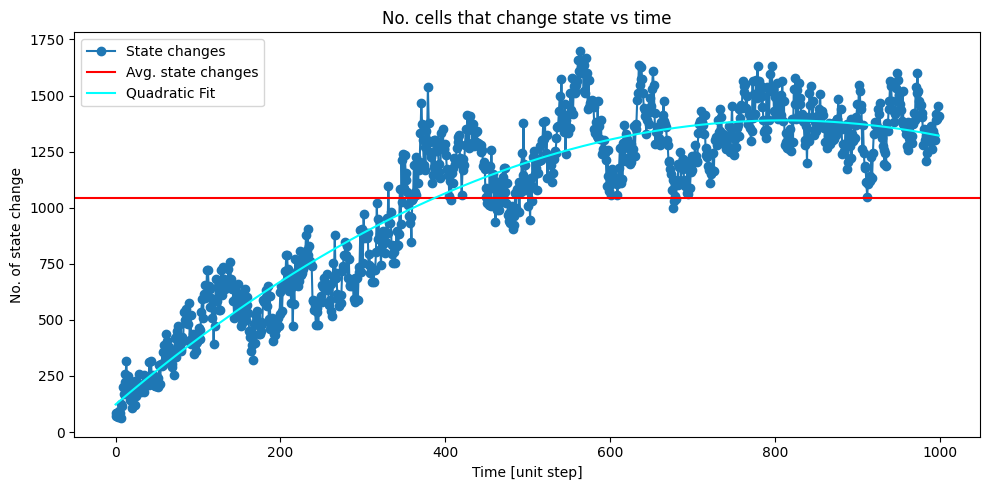

In [277]:
heat_teeth = analyseHeat(teeth_heat)
print("The average number of cells that change state at each generation is", heat_teeth)

fit(teeth_heat)